In [ ]:
!pip install hazm

In [2]:
import pandas as pd
import numpy as np
import sys, os
import math
from string import digits
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
from hazm import *
from hazm import stopwords_list
import numpy as np
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/thesis/data/6.labeled_data.csv')

Mounted at /content/drive


In [4]:
df.head()

,Unnamed: 0,answer,question,label
0,0,منبع این درس کامل,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0
1,2,همه چیز خیلی خوب بود,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0
2,3,فیلم کلاس های آنلاین خیلی کمک کرد,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0
3,4,بعضی وقت ها ذهن خسته‌س و دیدن فیلم سر فرصت خیل...,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0
4,6,عالی بود,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0


In [5]:
print("dataframe initial shape :" , df.shape)
columns = df.columns
print("dataframe column names :", columns)

dataframe initial shape : (725, 4)
dataframe column names : Index(['Unnamed: 0', 'answer', 'question', 'label'], dtype='object')


In [6]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
columns = df.columns

In [7]:
df.head()

,answer,question,label
0,منبع این درس کامل,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0
1,همه چیز خیلی خوب بود,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0
2,فیلم کلاس های آنلاین خیلی کمک کرد,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0
3,بعضی وقت ها ذهن خسته‌س و دیدن فیلم سر فرصت خیل...,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0
4,عالی بود,کلاس ها و منابع آموزشی درس تا چه حد در راستای ...,2.0


Clean the data and save it in two formats : 1. clean sentence 2. tokenized and word to vector

In [8]:
punctuation = "?.؟!،,"
normalizer = Normalizer()
lemmatizer = Lemmatizer()

def preprocessing(item):
    output = normalizer.normalize(item)
    output = output.replace("\_", "")
    for i in punctuation:
        output = output.replace(i, "")
    output = output.strip()

    if type(item) == str:
      try :
        item.encode(encoding='utf-8').decode('ascii')
      except UnicodeDecodeError:
        return output
      if len(item) == 1:
        # single character
        output = None
      else:
        # english sentence
        output = None
    else:
        # numerical value
        output = None
      
    return output

def clean(item):
  persian_stop_words = np.loadtxt('/content/drive/My Drive/thesis/data/stopwords.dat', dtype=str, delimiter='\n')
  tokenized = word_tokenize(item)
  no_stopwords = [word for word in tokenized if not word in persian_stop_words]
  lemmatized = [lemmatizer.lemmatize(word) for word in no_stopwords]
  final_string = ' '.join(lemmatized)
  return final_string

def concate_with_space(item):
  return item + " "

clean the data

In [11]:
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)

In [12]:
df['answer'] = df['answer'].apply(preprocessing)
df['answer'] = df['answer'].apply(concate_with_space)
df['question'] = df['question'].apply(preprocessing)

df['features'] = df['answer'] +  df['question']


df.dropna(inplace = True)
df.drop_duplicates(inplace = True)

df['features'] = df['features'].apply(clean)

df.dropna(inplace = True)
df.drop_duplicates(inplace = True)


Y = df.label.values
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoded_Y)

{'negative': 238, 'neutral': 52, 'positive': 229}
{0.0: 0.726890756302521, 1.0: 3.326923076923077, 2.0: 0.7554585152838428}


<BarContainer object of 3 artists>

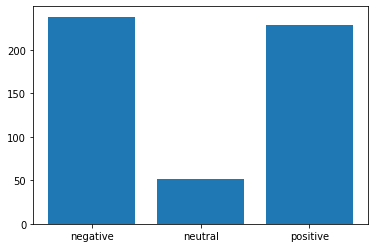

In [13]:
neg_count = len([e for e in df.label if e == 0])
neu_count = len([e for e in df.label if e == 1])
posi_count = len([e for e in df.label if e == 2])

labels_dict  = {'negative' : neg_count,
                'neutral':  neu_count,
                'positive':  posi_count}

print(labels_dict)


class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique( df.label),
                                        y =  df.label                                                 
                                    )
class_weights = dict(zip(np.unique( df.label), class_weights))

print(class_weights)

plt.bar(list(labels_dict.keys()), list(labels_dict.values()))

#First Split

save cleaned and preprocess data in train, validate and test proprtions

In [14]:
X_data, X_test, Y_data, Y_test = train_test_split(df['features'],dummy_y, test_size = 0.25, random_state = 42, stratify=dummy_y)
X_train, X_val, Y_train, Y_val = train_test_split(X_data,Y_data, test_size=0.25, random_state = 42, stratify=Y_data)

In [15]:
labels =  [np.where(r==1)[0][0] for r in Y_train]
labels_dict  = {'negative' : labels.count(0),
                'neutral':  labels.count(1),
                'positive':  labels.count(2)}
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique( labels),
                                        y =  labels                                             
                                    )
print(class_weights)
print(labels_dict)

labels =  [np.where(r==1)[0][0] for r in Y_test]
labels_dict  = {'negative' : labels.count(0),
                'neutral':  labels.count(1),
                'positive':  labels.count(2)}
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique( labels),
                                        y =  labels                                             
                                    )
print(class_weights)
print(labels_dict)


labels =  [np.where(r==1)[0][0] for r in Y_val]
labels_dict  = {'negative' : labels.count(0),
                'neutral':  labels.count(1),
                'positive':  labels.count(2)}
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique( labels),
                                        y =  labels                                             
                                    )
print(class_weights)
print(labels_dict)


[0.72932331 3.34482759 0.75193798]
{'negative': 133, 'neutral': 29, 'positive': 129}
[0.72222222 3.33333333 0.76023392]
{'negative': 60, 'neutral': 13, 'positive': 57}
[0.72592593 3.26666667 0.75968992]
{'negative': 45, 'neutral': 10, 'positive': 43}


In [16]:
# cleaned and proccessed data
X_train.to_csv(r'/content/drive/My Drive/thesis/data/processed_data/textual/X_train.csv', index = False)
X_val.to_csv('/content/drive/My Drive/thesis/data/processed_data/textual/X_val.csv',  index = False)
X_test.to_csv('/content/drive/My Drive/thesis/data/processed_data/textual/X_test.csv',  index = False)

np.savetxt('/content/drive/My Drive/thesis/data/processed_data/textual/Y_train.csv', Y_train, delimiter=",")
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/textual/Y_val.csv', Y_val, delimiter=",")
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/textual/Y_test.csv', Y_test, delimiter=",")

#Tokenize

In [ ]:
vocal_per_sentc = [len(x) for x in df.features.values]
print(max(vocal_per_sentc))

332


In [ ]:
maxlen = df['features'].apply(lambda x: len(word_tokenize(x))).max()
print(maxlen)

tokenizer = Tokenizer(num_words = max(vocal_per_sentc), split=" ")
tokenizer.fit_on_texts(df.features.values)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(df.features.values)
X = pad_sequences(X)

58


#Second Split

tokenize data and save in train, validate and test proportions. 

In [ ]:
X_data, X_test, Y_data, Y_test = train_test_split(X,dummy_y, test_size = 0.25, random_state = 42,stratify=dummy_y)
X_train, X_val, Y_train, Y_val = train_test_split(X_data,Y_data, test_size=0.25, random_state = 42,stratify=Y_data)

print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(291, 47) (291, 3)
(98, 47) (98, 3)
(130, 47) (130, 3)


In [ ]:
# tokenized data
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_train.csv', X_train, delimiter=",")
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_val.csv', X_val, delimiter=",")
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_test.csv', X_test, delimiter=",")

np.savetxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_train.csv', Y_train, delimiter=",")
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_val.csv', Y_val, delimiter=",")
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_test.csv', Y_test, delimiter=",")



# Third Split

separate question and answers and save as diffarante files to use in concatenated lstms

In [ ]:
# answer column 
vocal_per_sentc_answer = [len(x) for x in df.answer.values]
print(max(vocal_per_sentc_answer))
maxlen_answer = df['answer'].apply(lambda x: len(word_tokenize(x))).max()
print(maxlen_answer)

tokenizer_answer = Tokenizer(num_words = max(vocal_per_sentc_answer), split=" ")
tokenizer_answer.fit_on_texts(df.answer.values)
word_index_answer = tokenizer_answer.word_index
X_answer = tokenizer_answer.texts_to_sequences(df.answer.values)
X_answer = pad_sequences(X_answer)

# question column
vocal_per_sentc_question = [len(x) for x in df.question.values]
print(max(vocal_per_sentc_question))
maxlen_question = df['question'].apply(lambda x: len(word_tokenize(x))).max()
print(maxlen_question)

tokenizer_question = Tokenizer(num_words = max(vocal_per_sentc_question), split=" ")
tokenizer_question.fit_on_texts(df.question.values)
word_index_question = tokenizer_question.word_index
X_question = tokenizer_question.texts_to_sequences(df.question.values)
X_question = pad_sequences(X_question)

386
78
190
32


In [ ]:
print(X_answer.shape)
print(X_question.shape)
print(dummy_y.shape)

(519, 59)
(519, 32)
(519, 3)


In [ ]:
print("cleaned normalized tokenized answer column ")
print(X_answer)
print("with length" , len(X_answer), len(X_answer[0]))
print("cleaned normalized tokenized question column ")
print(X_question)
print("with length" , len(X_question), len(X_question[0]))

cleaned normalized tokenized answer column 
[[  0   0   0 ...  10   4 104]
 [  0   0   0 ...  20  16   5]
 [  0   0   0 ...  20  87 150]
 ...
 [  0   0   0 ...   4  43 103]
 [  0   0   0 ...  51   2 308]
 [  0   0   0 ...  19  72 206]]
with length 519 59
cleaned normalized tokenized question column 
[[ 0  0  0 ... 36 17  6]
 [ 0  0  0 ... 36 17  6]
 [ 0  0  0 ... 36 17  6]
 ...
 [ 0  0  0 ... 22 23 15]
 [ 0  0  0 ... 22 23 15]
 [57 58 25 ...  7 76 77]]
with length 519 32


In [ ]:

# separate tokenized data
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/separate_data/answer.csv', X_answer, delimiter=",")
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/separate_data/question.csv', X_question, delimiter=",")
np.savetxt('/content/drive/My Drive/thesis/data/processed_data/separate_data/labels.csv', dummy_y, delimiter=",")